In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import datetime

In [ ]:
def parser(x):
	return datetime.strptime(x, '%Y-%m')

In [ ]:
dataset = pd.read_csv('/content/drive/My Drive/Bootcamp ML2020/sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

In [ ]:
dataset.head(15)

Month
1960-01-01     6550
1960-02-01     8728
1960-03-01    12026
1960-04-01    14395
1960-05-01    14587
1960-06-01    13791
1960-07-01     9498
1960-08-01     8251
1960-09-01     7049
1960-10-01     9545
1960-11-01     9364
1960-12-01     8456
1961-01-01     7237
1961-02-01     9374
1961-03-01    11837
Name: Sales, dtype: int64

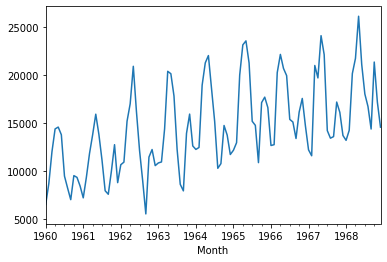

In [ ]:
dataset.plot()
plt.show()

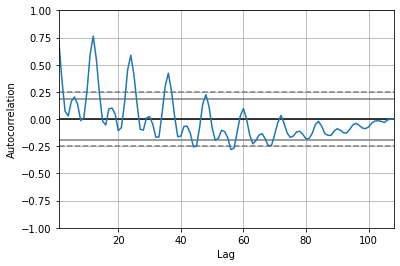

In [ ]:
pd.plotting.autocorrelation_plot(dataset)
plt.show()

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
model = ARIMA(dataset, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                  107
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -999.662
Method:                       css-mle   S.D. of innovations           2746.033
Date:                Thu, 17 Sep 2020   AIC                           2013.324
Time:                        09:54:22   BIC                           2032.033
Sample:                    02-01-1960   HQIC                          2020.908
                         - 12-01-1968                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            49.4520    191.309      0.258      0.797    -325.506     424.410
ar.L1.D.Sales     0.0558      0.095      0.587      0.559      -0.131       0.242
ar.L2.D.Sales     0.0026      0.093     

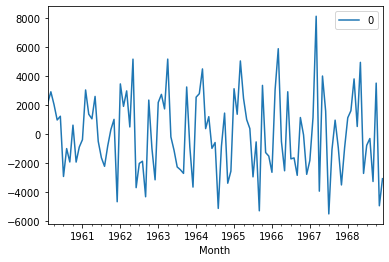

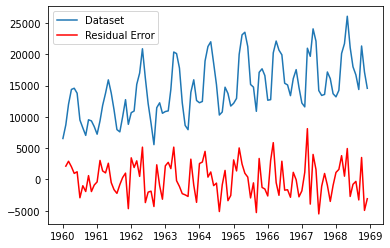

In [ ]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

plt.plot(dataset)
plt.plot(residuals,  color='red')
plt.legend(['Dataset','Residual Error'])

In [ ]:
residuals


,0
Month,
1960-02-01,2128.548031
1960-03-01,2915.680217
1960-04-01,2033.338491
1960-05-01,971.903287
1960-06-01,1229.069263
...,...
1968-08-01,-307.482105
1968-09-01,-3272.506864
1968-10-01,3513.162410


In [ ]:
print(residuals.describe())

                 0
count   107.000000
mean     34.235229
std    2767.781935
min   -5508.625814
25%   -1978.308988
50%    -307.482105
75%    2080.943261
max    8126.876825


In [ ]:
values = dataset.values
size = int(len(values) * 0.66)
train, test = values[0:size], values[size:len(values)]
history = [x for x in train]
predictions = []

for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	prediction = output[0]
	predictions.append(prediction)
	expected = test[t]
	history.append(expected)
	print('predicted=%f, expected=%f' % (prediction, expected))
error = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % error)

predicted=19178.213329, expected=16611.000000
predicted=14810.726195, expected=12674.000000
predicted=9933.264818, expected=12760.000000
predicted=13950.935600, expected=20249.000000
predicted=23834.156970, expected=22135.000000
predicted=23110.934931, expected=20677.000000
predicted=16702.380601, expected=19933.000000
predicted=18005.129132, expected=15388.000000
predicted=16162.623043, expected=15113.000000
predicted=16232.058750, expected=13401.000000
predicted=15013.433230, expected=16135.000000
predicted=17604.531487, expected=17562.000000
predicted=18006.947396, expected=14720.000000
predicted=13579.679006, expected=12225.000000
predicted=10613.242613, expected=11608.000000
predicted=12906.866003, expected=20985.000000
predicted=24445.752774, expected=19692.000000
predicted=19682.120832, expected=24081.000000
predicted=20224.841741, expected=22114.000000
predicted=20717.052380, expected=14220.000000
predicted=13889.497696, expected=13434.000000
predicted=13119.099193, expected=13

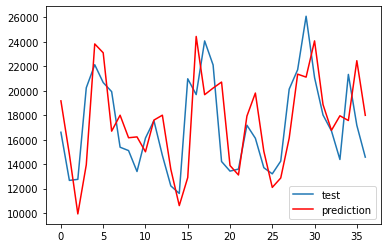

In [ ]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.legend(['test','prediction'])
plt.show()

In [ ]:
# Courtesy of Jason Brownlee of Machine Learning Mastery
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = mean_squared_error(test, predictions)
	return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [ ]:
import warnings

p_values = range(0, 10)
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=23860228.841
ARIMA(0, 0, 1) MSE=13871657.449
ARIMA(0, 1, 0) MSE=13540638.651
ARIMA(0, 1, 1) MSE=14145961.836
ARIMA(0, 1, 2) MSE=15295213.974
ARIMA(0, 2, 0) MSE=26660415.091
ARIMA(0, 2, 1) MSE=13968678.182
ARIMA(0, 2, 2) MSE=14572950.039
ARIMA(1, 0, 0) MSE=11723714.919
ARIMA(1, 0, 1) MSE=11799199.349
ARIMA(1, 0, 2) MSE=11389772.766
ARIMA(1, 1, 0) MSE=14164796.677
ARIMA(1, 2, 0) MSE=22748049.598
ARIMA(2, 0, 0) MSE=11999482.717
ARIMA(2, 0, 2) MSE=12577205.672
ARIMA(2, 1, 0) MSE=14304001.910
ARIMA(2, 2, 0) MSE=22715347.083
ARIMA(3, 0, 0) MSE=12128041.398
ARIMA(3, 1, 0) MSE=12696217.431
ARIMA(3, 2, 0) MSE=22046767.134
ARIMA(4, 0, 0) MSE=11631872.296
ARIMA(4, 1, 0) MSE=11387047.158
ARIMA(4, 2, 0) MSE=13540691.644
ARIMA(5, 0, 0) MSE=10954906.697
ARIMA(5, 1, 0) MSE=10778314.679
ARIMA(5, 2, 0) MSE=13784962.027
ARIMA(6, 0, 0) MSE=9993852.857
ARIMA(6, 1, 0) MSE=10818990.892
ARIMA(6, 2, 0) MSE=13578512.676
ARIMA(7, 0, 0) MSE=10411833.033
ARIMA(7, 1, 0) MSE=11855221.034
ARIMA(7, 

Untuk  **ARIMA**,  hasil terbaik MSE yang didapat adalah 9503244.126. pada parameter p(lag order)=9, d(nilai yang digunakan untuk membuat data stationary) dan q(ketergantungan antara observasi dan nilai) = 0


In [ ]:
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
# Courtesy of Jason Brownlee of Machine Learning Mastery
# one-step sarima forecast
def sarima_forecast(history, config):
	order, sorder, trend = config
	# define model
	model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
	# fit model
	model_fit = model.fit(disp=False)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history))
	return yhat[0]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = sarima_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
	models = list()
	# define config lists
	p_params = [0, 1, 2]
	d_params = [0, 1]
	q_params = [0, 1, 2]
	t_params = ['n','c','t','ct']
	P_params = [0, 1, 2]
	D_params = [0, 1]
	Q_params = [0, 1, 2]
	m_params = seasonal
	# create config instances
	for p in p_params:
		for d in d_params:
			for q in q_params:
				for t in t_params:
					for P in P_params:
						for D in D_params:
							for Q in Q_params:
								for m in m_params:
									cfg = [(p,d,q), (P,D,Q,m), t]
									models.append(cfg)
	return models

In [ ]:
n_test = 12

# model configs
cfg_list = sarima_configs()

# grid search
scores = grid_search(dataset, cfg_list, n_test)
print('done')

# list top 3 configs
for cfg, error in scores[:3]:
  print(cfg, error)

 > Model[[(0, 0, 0), (0, 0, 0, 0), 'n']] 18608.652
 > Model[[(0, 0, 0), (0, 0, 1, 0), 'n']] 9928.438
 > Model[[(0, 0, 0), (1, 0, 0, 0), 'n']] 3798.000
 > Model[[(0, 0, 0), (0, 0, 2, 0), 'n']] 7278.585
 > Model[[(0, 0, 0), (1, 0, 1, 0), 'n']] 3942.265
 > Model[[(0, 0, 0), (1, 0, 2, 0), 'n']] 3852.155
 > Model[[(0, 0, 0), (2, 0, 0, 0), 'n']] 3924.991
 > Model[[(0, 0, 0), (2, 0, 1, 0), 'n']] 3949.171
 > Model[[(0, 0, 0), (0, 0, 0, 0), 'c']] 5399.238
 > Model[[(0, 0, 0), (0, 0, 1, 0), 'c']] 4061.377
 > Model[[(0, 0, 0), (2, 0, 2, 0), 'n']] 3440.470
 > Model[[(0, 0, 0), (0, 0, 2, 0), 'c']] 4130.492
 > Model[[(0, 0, 0), (1, 0, 1, 0), 'c']] 3816.618
 > Model[[(0, 0, 0), (1, 0, 0, 0), 'c']] 3502.309
 > Model[[(0, 0, 0), (1, 0, 2, 0), 'c']] 3478.543
 > Model[[(0, 0, 0), (2, 0, 0, 0), 'c']] 4094.032
 > Model[[(0, 0, 0), (2, 0, 1, 0), 'c']] 3493.332
 > Model[[(0, 0, 0), (0, 0, 0, 0), 't']] 6760.052
 > Model[[(0, 0, 0), (0, 0, 1, 0), 't']] 4512.298
 > Model[[(0, 0, 0), (2, 0, 2, 0), 'c']] 3378.390

Berdasarkan Output diatas, dengan menggunakan model SARIMA didapatkanlah nilai RMSE terbaik pada p = 9, d = 1, dan q = 0 untuk autoregression.
sedangkan untuk seasonal nya dengan parameter P = 2, dan Q, D, dan M = 0.
dari grafik dapat kita lihat bahwa terdapat Trend yang bernilai konstan dari waktu ke waktu, dan Seasonal namun kenaikan data nya relatif rendah


Setelah kita membandingkan nilai Arima dan Sarima, maka dapat kita simpulkan bahwa, untuk dataset yang kita gunakan lebih baik menggunakan model Sarima, karena seperti yang dapat kita lihat pada chart sebelumnya kita dapat menyimpulkan bahwa diagram membentuk sebuah trend dan seasonality